## Dual Governance Agent-based modelling


In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

# radCAD
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

pd.options.display.float_format = "{:.2f}".format

%matplotlib inline

In [21]:
from model.state_update_blocks import state_update_blocks
from model.sys_params import sys_params
from model.types.proposal_type import ProposalGeneration, ProposalSubType, ProposalType
from model.types.proposals import Proposal
from model.types.reaction_time import ModeledReactions
from model.types.scenario import Scenario
from model.utils.initialization import generate_initial_state
from model.utils.postprocessing import postprocessing

MONTE_CARLO_RUNS = 1
TIMESTEPS = 40

proposals = [
    Proposal(
        timestep=10,
        damage=45,
        proposal_type=ProposalType.Negative,
        sub_type=ProposalSubType.FundsStealing,
        proposer="0x98078db053902644191f93988341e31289e1c8fe",
        attack_targets={"0x3e40d73eb977dc6a537af587d48316fee66e9c8c"},
    ),
]

attackers = {"0x98078db053902644191f93988341e31289e1c8fe", "0xc329400492c6ff2438472d4651ad17389fcb843a"}

state = generate_initial_state(
    Scenario.SingleAttack,
    ModeledReactions.Normal,
    ProposalType.Negative,
    ProposalSubType.NoEffect,
    ProposalGeneration.Random,
    initial_proposals=proposals,
    attackers=attackers,
)

model = Model(
    initial_state=state,
    params=sys_params,
    state_update_blocks=state_update_blocks,
)

simulation = Simulation(model=model, timesteps=TIMESTEPS, runs=MONTE_CARLO_RUNS)
simulation.engine = Engine(backend=Backend.MULTIPROCESSING, processes=5, raise_exceptions=False, drop_substeps=True)

result = simulation.run()
df = pd.DataFrame(result)
post_processing = postprocessing(df)
exceptions = simulation.exceptions

[]
[Proposal(proposal_type=<ProposalType.Negative: 2>, proposer='0x98078db053902644191f93988341e31289e1c8fe', id=1, damage=45, timestep=10, sub_type=<ProposalSubType.FundsStealing: 2>, attack_targets={'0x3e40d73eb977dc6a537af587d48316fee66e9c8c'})]
{'0x98078db053902644191f93988341e31289e1c8fe', '0xc329400492c6ff2438472d4651ad17389fcb843a'}
identified non initialized proposal
submitting proposal with ID 1 at  2024-08-31 10:54:11.887302
2  attackers in the system that is going to steal  0  stETH and  0  wstETH
stealing from honest actors  0.0  stETH and  0.0  wstETH
Proposal(proposal_type=<ProposalType.Negative: 2>, proposer='0x98078db053902644191f93988341e31289e1c8fe', id=1, damage=45, timestep=10, sub_type=<ProposalSubType.FundsStealing: 2>, attack_targets={'0x3e40d73eb977dc6a537af587d48316fee66e9c8c'})
Proposal ID 1 is going to be canceled.
last_canceled_proposal 0
need to cancel proposals
[1]
deactivating attack
actor_reset_proposal_effect [1]
rare case
rare case


In [22]:
submitted_proposals = sum([proposal for proposal in post_processing["proposals_submitted_count"].tail(1)])
canceled_proposals = sum([proposal for proposal in post_processing["proposals_canceled_count"].tail(1)])
proposals_damage = sum([proposal for proposal in post_processing["total_damage_of_proposals"].tail(1)])
average_damage = sum([proposal for proposal in post_processing["average_damage_per_proposal"].tail(1)])

display(Markdown("### Results summary"))
display(Markdown(f"##### Submitted Proposals: **{submitted_proposals}**"))
display(Markdown(f"##### Canceled Proposals: **{canceled_proposals}**"))
display(Markdown(f"##### Total Damage of Proposals: **{proposals_damage}**"))
display(Markdown(f"##### Average Damage per Proposal: **{average_damage}**"))

### Results summary

##### Submitted Proposals: **1**

##### Canceled Proposals: **1**

##### Total Damage of Proposals: **45**

##### Average Damage per Proposal: **45**

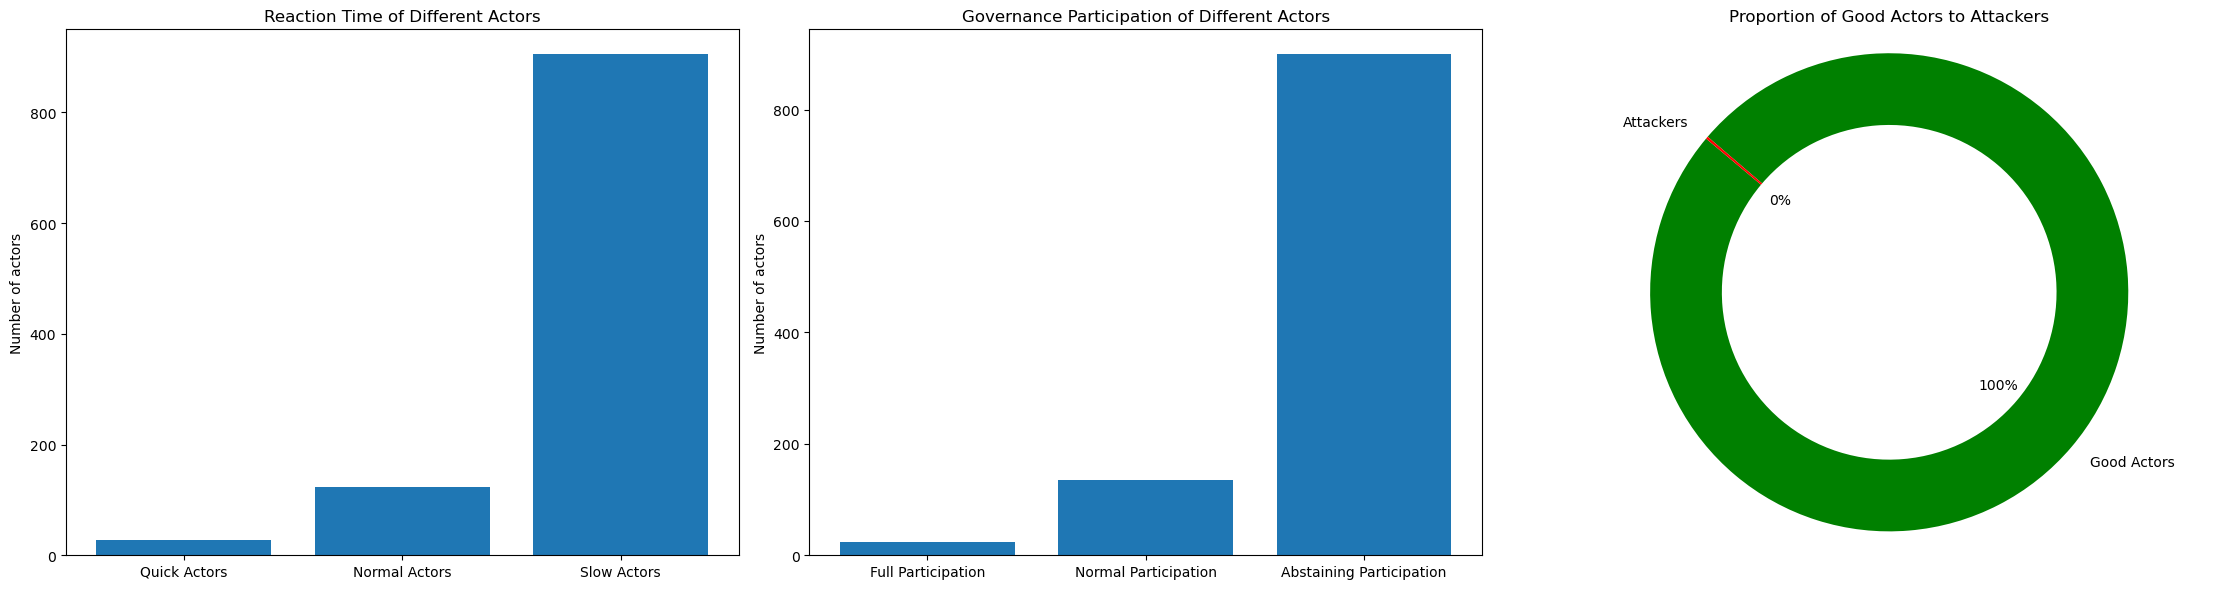

In [23]:
import matplotlib.pyplot as plt


def create_charts(post_processing, bar_charts, donut_chart):
    num_bar_charts = len(bar_charts)
    fig, axs = plt.subplots(1, num_bar_charts + 1, figsize=(7.5 * (num_bar_charts + 1), 6))

    if num_bar_charts == 1:
        axs = [axs[0], axs[1]]  # Ensure axs is always a list
    elif num_bar_charts == 2:
        axs = [axs[0], axs[1], axs[2]]

    # Plot bar charts
    for i, (attributes, labels, title, ylabel) in enumerate(bar_charts):
        values = [getattr(post_processing, attr).tail(1).values[0] for attr in attributes]
        axs[i].bar(labels, values)
        axs[i].set_title(title)
        axs[i].set_xlabel("")
        axs[i].set_ylabel(ylabel)

    # Plot donut chart
    labels, sizes, colors, title = donut_chart
    values = [getattr(post_processing, attr).tail(1).values[0] for attr in sizes]
    axs[-1].pie(
        values,
        labels=labels,
        colors=colors,
        autopct=lambda p: f"{p:.0f}%" if p > 0 else "0",
        startangle=140,
        wedgeprops=dict(width=0.3),
    )
    axs[-1].set_title(title)
    axs[-1].axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    plt.show()


# Example usage
values = [
    "total_quick_actors_reaction_time",
    "total_normal_actors_reaction_time",
    "total_slow_actors_reaction_time",
]
values_2 = [
    "total_full_governance_participants",
    "total_normal_governance_participants",
    "total_abstaining_governance_participants",
]

labels = ["Quick Actors", "Normal Actors", "Slow Actors"]
labels_2 = ["Full Participation", "Normal Participation", "Abstaining Participation"]

chart_1 = (values, labels, "Reaction Time of Different Actors", "Number of actors")
chart_2 = (values_2, labels_2, "Governance Participation of Different Actors", "Number of actors")

donut_chart = (
    ["Good Actors", "Attackers"],
    ["total_stETH_good_actors", "total_attackers"],
    ["green", "red"],
    "Proportion of Good Actors to Attackers",
)

create_charts(post_processing, [chart_1, chart_2], donut_chart)

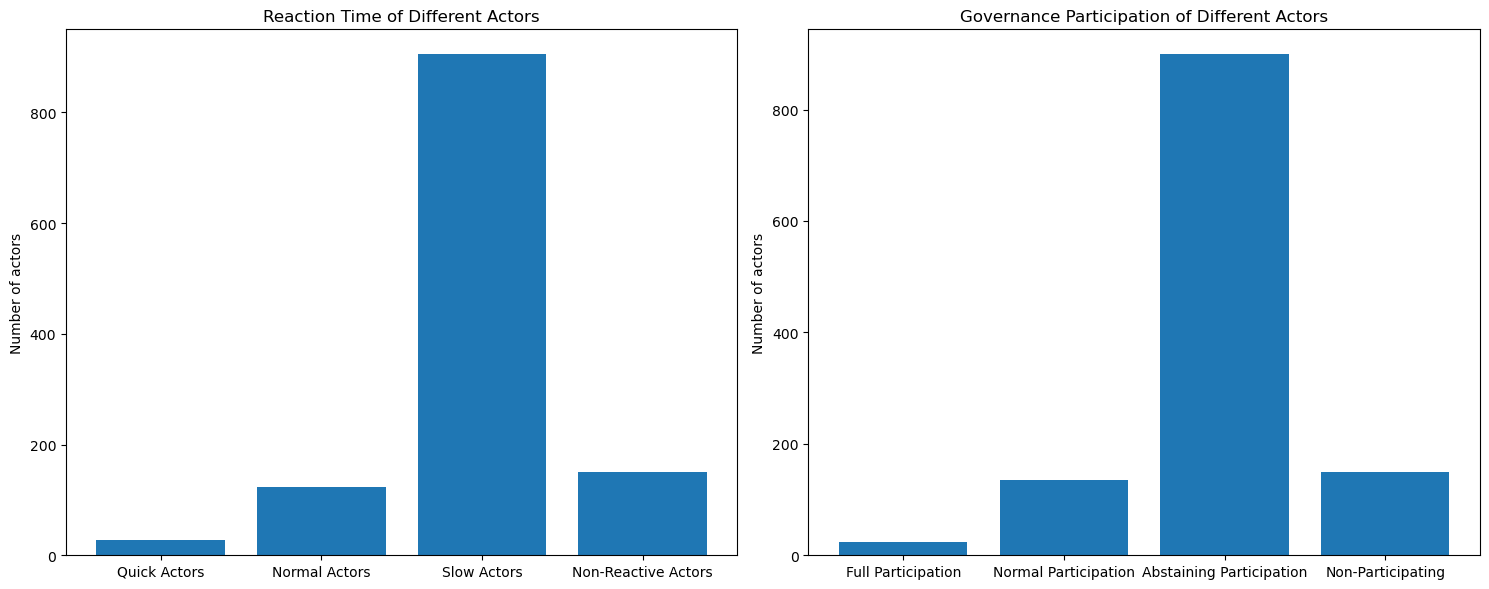

In [24]:
from model.utils.charts import create_bar_charts

values = [
    "total_quick_actors_reaction_time",
    "total_normal_actors_reaction_time",
    "total_slow_actors_reaction_time",
    "total_non_reactive_actors_reaction_time",
]
values_2 = [
    "total_full_governance_participants",
    "total_normal_governance_participants",
    "total_abstaining_governance_participants",
    "total_non_participating_governance_participants",
]

labels = ["Quick Actors", "Normal Actors", "Slow Actors", "Non-Reactive Actors"]
labels_2 = ["Full Participation", "Normal Participation", "Abstaining Participation", "Non-Participating"]

chart_1 = (values, labels, "Reaction Time of Different Actors", "Number of actors")
chart_2 = (values_2, labels_2, "Governance Participation of Different Actors", "Number of actors")

create_bar_charts(post_processing, chart_1, chart_2)

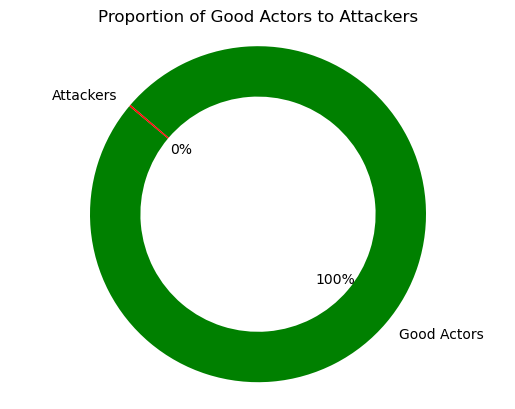

In [25]:
labels = "Good Actors", "Attackers"
sizes = ["total_stETH_good_actors", "total_attackers"]
values = [getattr(post_processing, attr).tail(1).values[0] for attr in sizes]
colors = ["green", "red"]
autopct = lambda p: f"{p:.0f}%" if p > 0 else "0"

plt.pie(
    values,
    labels=labels,
    colors=colors,
    autopct=lambda p: f"{p:.0f}%" if p > 0 else "0",
    startangle=140,
    wedgeprops=dict(
        width=0.3,
    ),
)

plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Proportion of Good Actors to Attackers")
plt.show()

In [26]:
post_processing.head(5)

,dg_state,current_time,total_actors_health,total_contracts_health,total_honest_actors_health,total_attackers_actors_health,total_actors_damaged,total_actors_recovery,total_stETH_balance,total_stETH_locked,...,total_slow_actors_reaction_time,total_non_reactive_actors_reaction_time,total_full_governance_participants,total_normal_governance_participants,total_abstaining_governance_participants,total_non_participating_governance_participants,total_stETH_good_actors,total_attackers,timestep,run
1,State.Normal,2024-08-30 07:54:11.887302,59292,7101,59218,74,0,0,4687871.40,0.00,...,905,150,23,135,899,150,1205,2,1,1
2,State.Normal,2024-08-30 10:54:11.887302,59292,7101,59218,74,0,0,4687871.40,0.00,...,905,150,23,135,899,150,1205,2,2,1
3,State.Normal,2024-08-30 13:54:11.887302,59292,7101,59218,74,0,0,4687871.40,0.00,...,905,150,23,135,899,150,1205,2,3,1
4,State.Normal,2024-08-30 16:54:11.887302,59292,7101,59218,74,0,0,4687871.40,0.00,...,905,150,23,135,899,150,1205,2,4,1
5,State.Normal,2024-08-30 19:54:11.887302,59292,7101,59218,74,0,0,4687871.40,0.00,...,905,150,23,135,899,150,1205,2,5,1


In [27]:
post_processing.tail(5)

,dg_state,current_time,total_actors_health,total_contracts_health,total_honest_actors_health,total_attackers_actors_health,total_actors_damaged,total_actors_recovery,total_stETH_balance,total_stETH_locked,...,total_slow_actors_reaction_time,total_non_reactive_actors_reaction_time,total_full_governance_participants,total_normal_governance_participants,total_abstaining_governance_participants,total_non_participating_governance_participants,total_stETH_good_actors,total_attackers,timestep,run
36,State.VetoSignallingDeactivation,2024-09-03 16:54:11.887302,59292,7101,59218,74,41004,41004,4637932.08,50942.37,...,905,150,23,135,899,150,1205,2,36,1
37,State.VetoSignallingDeactivation,2024-09-03 19:54:11.887302,59292,7101,59218,74,41004,41004,4642445.88,46428.57,...,905,150,23,135,899,150,1205,2,37,1
38,State.VetoSignallingDeactivation,2024-09-03 22:54:11.887302,59292,7101,59218,74,41004,41004,4682005.16,41152.02,...,905,150,23,135,899,150,1205,2,38,1
39,State.VetoSignallingDeactivation,2024-09-04 01:54:11.887302,59292,7101,59218,74,41004,41004,4685027.17,38130.01,...,905,150,23,135,899,150,1205,2,39,1
40,State.VetoSignallingDeactivation,2024-09-04 04:54:11.887302,59292,7101,59218,74,41004,41004,4690885.44,32271.74,...,905,150,23,135,899,150,1205,2,40,1


#### Results Summary

##### Time from maximum normalized_damaged to maximum combined_percentage_locked: **54 hours** (2.25 days)

##### Maximum percentage of rage quit support : **3.05 %**

##### Maximum number of locked tokens : **95351.12 stETH** and **116967.88 wstETH**

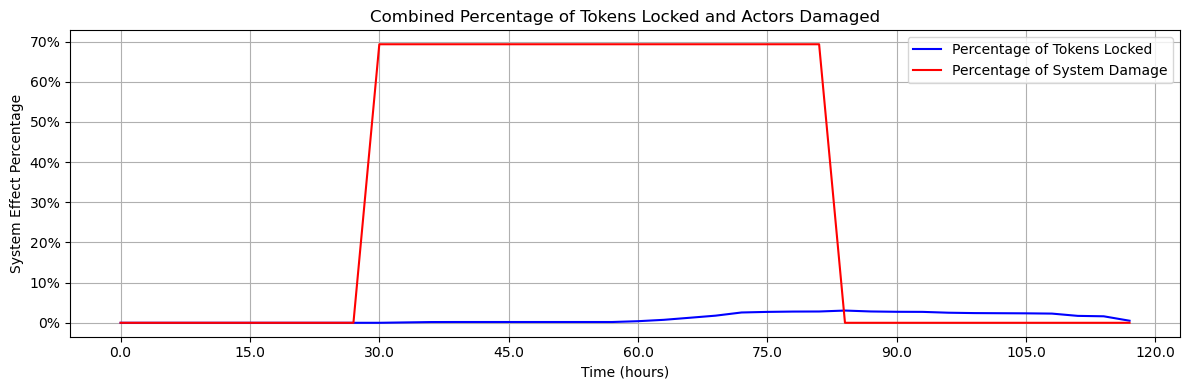

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

total_stETH_balance = post_processing["total_stETH_balance"]
total_stETH_locked = post_processing["total_stETH_locked"]
total_wstETH_balance = post_processing["total_wstETH_balance"]
total_wstETH_locked = post_processing["total_wstETH_locked"]
total_actors_damaged = post_processing["total_actors_damaged"]
total_actors_health = post_processing["total_actors_health"]
total_actors_recovery = post_processing["total_actors_recovery"]
rage_quit_support = post_processing["rage_quit_support"]
timesteps = range(len(total_stETH_balance))

combined_balance = total_stETH_balance + total_wstETH_balance + total_stETH_locked + total_wstETH_locked
combined_locked = total_stETH_locked + total_wstETH_locked

percentage_locked = [
    (locked / balance) if balance != 0 else 0 for locked, balance in zip(combined_locked, combined_balance)
]

normalized_damaged = [
    (damaged - recovery) / (health + damaged - recovery)
    for damaged, recovery, health in zip(total_actors_damaged, total_actors_recovery, total_actors_health)
]

max_normalized_damaged_idx = normalized_damaged.index(max(normalized_damaged))
max_normalized_damaged_ts = timesteps[max_normalized_damaged_idx]

max_combined_percentage_locked_idx = percentage_locked.index(max(percentage_locked))
max_combined_percentage_locked_ts = timesteps[max_combined_percentage_locked_idx]

time_difference = max_combined_percentage_locked_ts - max_normalized_damaged_ts
time_difference_hours = time_difference * 3
time_difference_days = time_difference_hours / 24

display(Markdown("#### Results Summary"))
display(
    Markdown(
        f"##### Time from maximum normalized_damaged to maximum combined_percentage_locked: **{time_difference_hours} hours** ({time_difference_days:.2f} days)"
    )
)
display(Markdown(f"##### Maximum percentage of rage quit support : **{rage_quit_support.max():.2f} %**"))
display(
    Markdown(
        f"##### Maximum number of locked tokens : **{total_stETH_locked.max():.2f} stETH** and **{total_wstETH_locked.max():.2f} wstETH**"
    )
)

plt.figure(figsize=(12, 4))

plt.plot(timesteps, percentage_locked, color="blue", label="Percentage of Tokens Locked")
plt.xlabel("Time (hours)")
plt.ylabel("Percentage of Tokens Locked")
plt.title("Combined Percentage of Tokens Locked and Actors Damaged")
plt.grid(True)

plt.plot(timesteps, normalized_damaged, color="red", label="Percentage of System Damage")
plt.xlabel("Time (hours)")
plt.ylabel("System Effect Percentage")
plt.legend()
plt.grid(True)

plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))

plt.tight_layout()
plt.show()

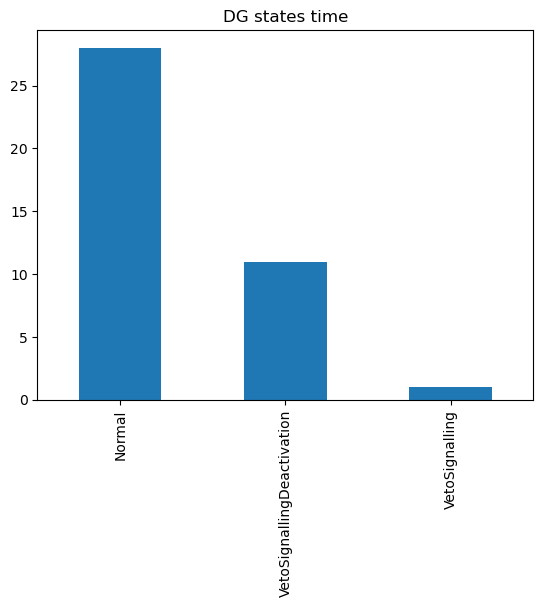

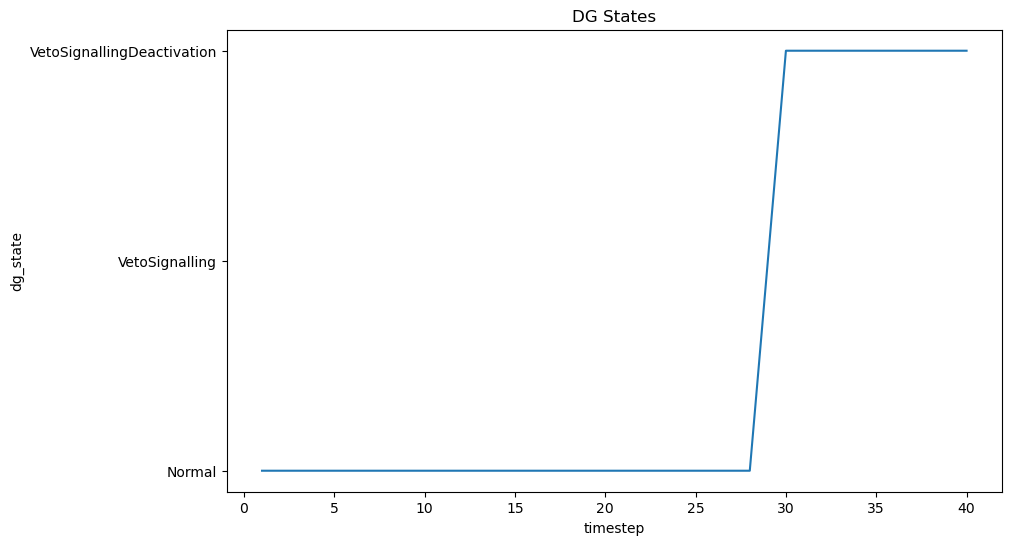

In [29]:
from model.utils.charts import state_plot, monte_carlo_plot


state_plot(post_processing, "timestep", "dg_state", 1)

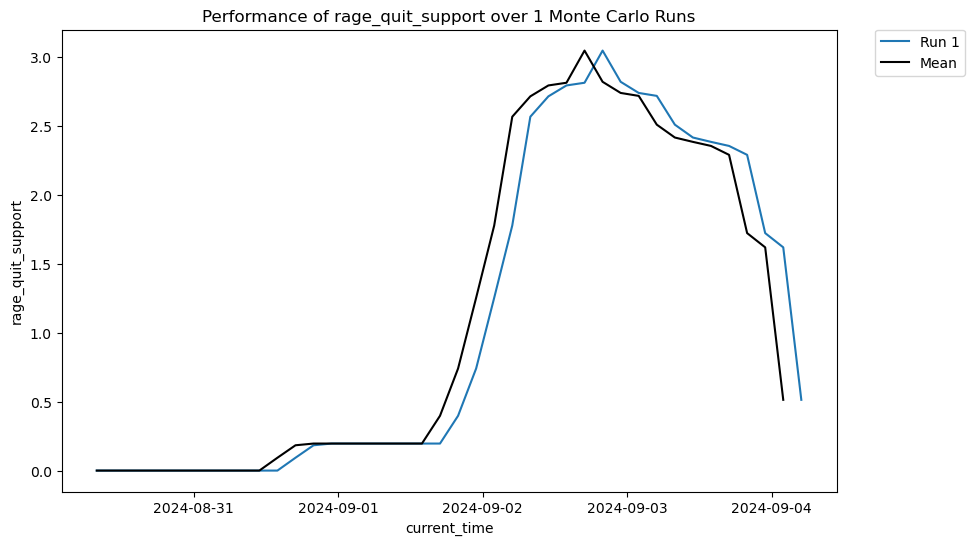

In [30]:
monte_carlo_plot(post_processing, "timestep", "current_time", "rage_quit_support", 1)

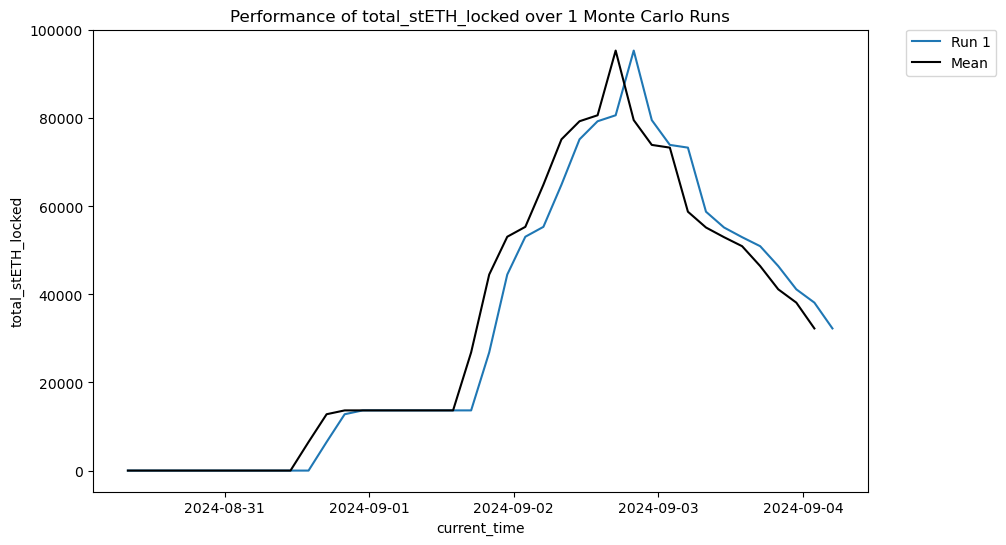

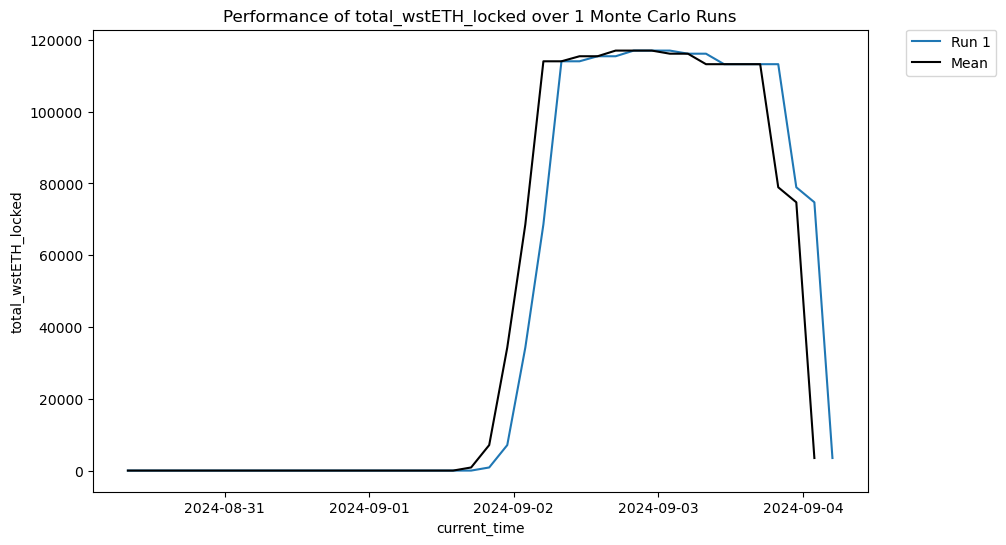

In [31]:
monte_carlo_plot(post_processing, "timestep", "current_time", "total_stETH_locked", 1)
monte_carlo_plot(post_processing, "timestep", "current_time", "total_wstETH_locked", 1)